<a href="https://colab.research.google.com/github/A23929/MDSC-302-Assignments/blob/main/22237_MDSC_302(P)_ESE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
from torchvision.transforms import v2


/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.Caltech101(
    root="data",
    download=True,
    transform= v2.Compose([
    v2.Grayscale(3),
    v2.Resize(size=(224, 224)),
    v2.ToTensor()])
    # Or Resize(antialias=True)
)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
labels = training_data.annotation_categories

<ipython-input-6-2e93e9e6e0c3>:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(img.T, cmap="gray")


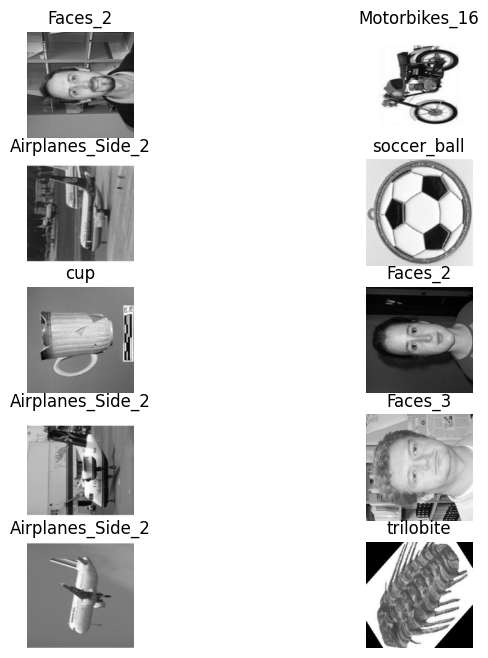

In [ ]:
labels_map = {}
for i in range(len(labels)):
  labels_map[i] = labels[i]

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.T, cmap="gray")
plt.show()

torch.Size([3, 224, 224])

In [ ]:
from torch.utils.data.dataset import random_split

In [ ]:
train_size = 0.6 * len(training_data)
val_size = 0.2 * len(training_data)
test_size = 0.2 * len(training_data)
train_set, val_set, test_set = random_split(training_data,[0.6,0.2,0.2])

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 7)
        self.pool1 = nn.MaxPool2d(7,7)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.pool2 = nn.MaxPool2d(3,3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool3 = nn.MaxPool2d(3,3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.pool4 = nn.MaxPool2d(3,3)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.pool5 = nn.AvgPool2d(3, 3)
        self.fc1 = nn.Linear(512*6*6, 120)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x

In [ ]:
net = CNNet()

AttributeError: ignored

In [ ]:
model = CNNet().to(device)
print(model)

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [ ]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        dataloaders = {'train' : train_dataloader, 'val': val_dataloader}
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(dataloaders[phase])
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model

In [ ]:
model_ft = train_model(model, loss_fn, optimizer, learning_rate, num_epochs=5)

Epoch 0/4
----------


RuntimeError: ignored